In [1]:
# !pip3 install kagglehub

In [1]:
import os
import numpy as np
import cv2
import pickle

def load_images_and_labels(dataset_path, img_size=(128, 128)):
    images, labels = [], []
    for label, folder_name in enumerate(["real", "fake"]):
        folder_path = os.path.join(dataset_path, folder_name)
        for filename in os.listdir(folder_path):
            img_path = os.path.join(folder_path, filename)
            img = cv2.imread(img_path)
            if img is not None:
                img = cv2.resize(img, img_size)
                images.append(img)
                labels.append(label)  # 1 for real, 0 for fake
    return np.array(images), np.array(labels)

# Load dataset
dataset_path = 'Minor Project/Dataset/test'  # Set your dataset path here
images, labels = load_images_and_labels(dataset_path)

# Save labels as a pickle file for use in the UI
with open('labels.pkl', 'wb') as f:
    pickle.dump(labels, f)

In [2]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

# Data Preprocessing
images = images / 255.0  # Normalize pixel values
labels = to_categorical(labels, 2)  # One-hot encode labels
x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

# Save datasets as pickle files
with open('x_train.pkl', 'wb') as f:
    pickle.dump(x_train, f)
with open('x_test.pkl', 'wb') as f:
    pickle.dump(x_test, f)
with open('y_train.pkl', 'wb') as f:
    pickle.dump(y_train, f)
with open('y_test.pkl', 'wb') as f:
    pickle.dump(y_test, f)

/Users/adityarajhanda/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [3]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

def build_cnn_model(input_shape=(128, 128, 3)):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(2, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Initialize and print CNN model architecture
model = build_cnn_model()
model.summary()  # This prints the architecture of the CNN model

/Users/adityarajhanda/Library/Python/3.9/lib/python/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,304,898 (12.61 MB)

 Trainable params: 3,304,898 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

In [4]:
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from datetime import datetime

# Define directory for TensorBoard logs
log_dir = "logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")

# Cross-Validation and Training with Early Stopping and TensorBoard
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
fold_no = 1
for train, val in kfold.split(x_train, np.argmax(y_train, axis=1)):
    print(f"Training fold {fold_no}...")
    model = build_cnn_model()
    
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

    history = model.fit(
        x_train[train], y_train[train],
        validation_data=(x_train[val], y_train[val]),
        epochs=10,
        batch_size=32,
        callbacks=[early_stopping, tensorboard_callback]
    )
    fold_no += 1

# Save the trained model
model.save('cnn_image_classification_model.h5')

Training fold 1...


/Users/adityarajhanda/Library/Python/3.9/lib/python/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 46s 114ms/step - accuracy: 0.6826 - loss: 0.5782 - val_accuracy: 0.7984 - val_loss: 0.4303
Epoch 2/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 41s 102ms/step - accuracy: 0.8105 - loss: 0.4148 - val_accuracy: 0.8241 - val_loss: 0.4219
Epoch 3/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 41s 104ms/step - accuracy: 0.8453 - loss: 0.3627 - val_accuracy: 0.8813 - val_loss: 0.3024
Epoch 4/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 41s 102ms/step - accuracy: 0.8718 - loss: 0.2979 - val_accuracy: 0.8847 - val_loss: 0.2983
Epoch 5/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 40s 100ms/step - accuracy: 0.8930 - loss: 0.2589 - val_accuracy: 0.8928 - val_loss: 0.2654
Epoch 6/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 40s 101ms/step - accuracy: 0.9099 - loss: 0.2212 - val_accuracy: 0.9056 - val_loss: 0.2451
Epoch 7/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 42s 104ms/step - accuracy: 0.9245 - loss: 0.1892 - val_accuracy: 0.8891 - val_loss: 0.2782
Epoch 8/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 40s 101ms/step - accuracy: 0.9353 - loss: 0

In [5]:
from sklearn.metrics import confusion_matrix, classification_report

y_pred = model.predict(x_test)
y_pred_labels = np.argmax(y_pred, axis=1)
y_test_labels = np.argmax(y_test, axis=1)

conf_matrix = confusion_matrix(y_test_labels, y_pred_labels)
class_report = classification_report(y_test_labels, y_pred_labels, output_dict=True)

# Save evaluation results as a pickle file
evaluation_results = {
    "confusion_matrix": conf_matrix,
    "classification_report": class_report
}

with open('evaluation_results.pkl', 'wb') as f:
    pickle.dump(evaluation_results, f)

125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step


In [1]:
import random
import matplotlib.pyplot as plt
import tensorflow as tf

def predict_random_image(model_path='cnn_image_classification_model.h5'):
    # Load the model
    model = tf.keras.models.load_model(model_path)
    
    # Pick a random image from the test set
    random_index = random.randint(0, x_test.shape[0] - 1)
    random_image = x_test[random_index]
    true_label = np.argmax(y_test[random_index])
    
    # Prepare image for prediction
    img = np.expand_dims(random_image, axis=0)  # Add batch dimension
    prediction = model.predict(img)
    predicted_label = np.argmax(prediction, axis=1)[0]
    
    # Map labels to class names
    label_map = {0: "Fake", 1: "Real"}
    print(f"True label: {label_map[true_label]}, Predicted label: {label_map[predicted_label]}")
    return random_image, true_label, predicted_label

# Test prediction function with a random image
random_image, true_label, predicted_label = predict_random_image()

# Display the random image with prediction result
plt.imshow(random_image)
plt.title(f"Prediction: {'Real' if predicted_label == 1 else 'Fake'}")
plt.show()

/Users/adityarajhanda/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


NameError: name 'x_test' is not defined

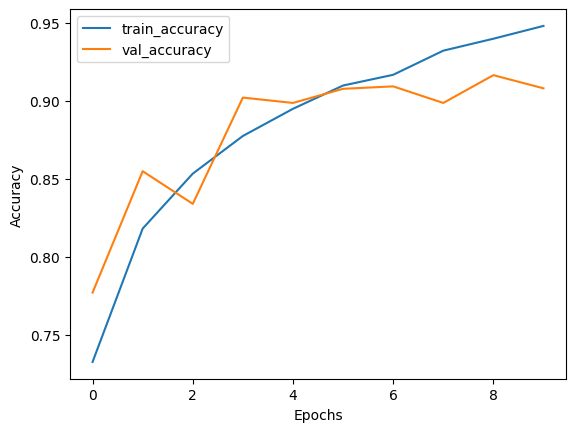

In [7]:
# Plot training history
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step
Confusion Matrix:
 [[1873  146]
 [ 232 1749]]

Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.93      0.91      2019
           1       0.92      0.88      0.90      1981

    accuracy                           0.91      4000
   macro avg       0.91      0.91      0.91      4000
weighted avg       0.91      0.91      0.91      4000

Training history file (history.pkl) not found.


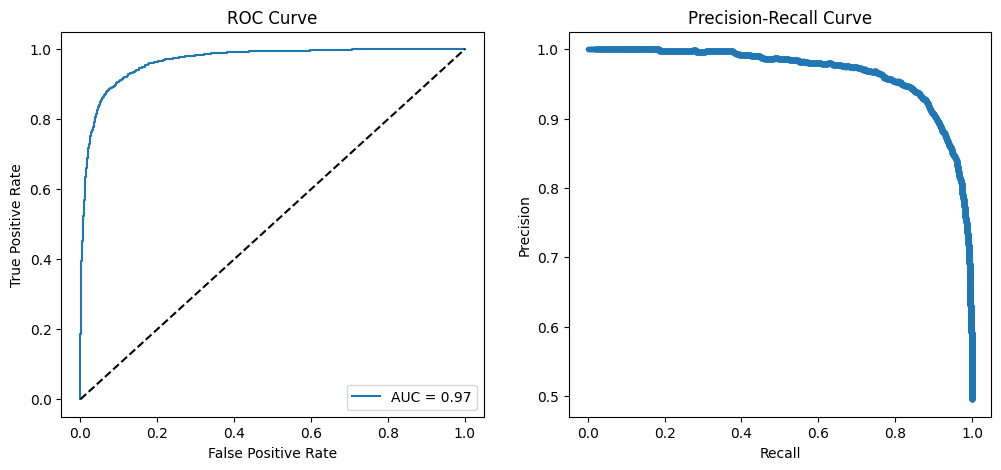

In [2]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, precision_recall_curve
import tensorflow as tf

# Step 1: Load Pickle Files (x_test, y_test, Trained Model)
with open('x_test.pkl', 'rb') as f:
    x_test = pickle.load(f)
with open('y_test.pkl', 'rb') as f:
    y_test = pickle.load(f)
    
# Load the trained model
model = tf.keras.models.load_model('cnn_image_classification_model.h5')

# Step 2: Model Evaluation and Prediction
y_pred = model.predict(x_test)
y_pred_labels = np.argmax(y_pred, axis=1)
y_test_labels = np.argmax(y_test, axis=1)

# Step 3: Confusion Matrix and Classification Report
conf_matrix = confusion_matrix(y_test_labels, y_pred_labels)
class_report = classification_report(y_test_labels, y_pred_labels)
print("Confusion Matrix:\n", conf_matrix)
print("\nClassification Report:\n", class_report)

# Step 4: Accuracy and Loss Plot (Load history.pkl if available)
try:
    with open('history.pkl', 'rb') as f:
        history = pickle.load(f)
    
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history['accuracy'], label='Training Accuracy')
    plt.plot(history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Accuracy Curve')

    plt.subplot(1, 2, 2)
    plt.plot(history['loss'], label='Training Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Loss Curve')
    plt.show()
except FileNotFoundError:
    print("Training history file (history.pkl) not found.")

# Step 5: ROC Curve and Precision-Recall Curve
fpr, tpr, _ = roc_curve(y_test_labels, y_pred[:, 1])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(12, 5))

# ROC Curve
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test_labels, y_pred[:, 1])
plt.subplot(1, 2, 2)
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

# Step 6: Save Evaluation Results
evaluation_results = {
    "confusion_matrix": conf_matrix,
    "classification_report": class_report,
    "roc_auc": roc_auc,
}

with open('evaluation_results.pkl', 'wb') as f:
    pickle.dump(evaluation_results, f)